## Import necessary libraries

In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix

## Function to Load images and labels

In [4]:
# Path to the extracted dataset
dataset_path = 'Desktop/CV/milestone_2'

def load_casia_webface_data(dataset_path, max_classes, min_images_per_class):
    images = []
    labels = []
    label_map = {}
    current_label = 0

    # Walk through dataset directories
    for subdir, dirs, _ in os.walk(dataset_path):
        for dir_name in sorted(dirs):  # Sorting for consistency
            # Skip the "casia-webface" folder or any unwanted folder
            if dir_name == 'casia-webface':
                #print(f"Skipping folder: {dir_name}")
                continue

            if current_label >= max_classes:
                break  # Stop after reaching max_classes

            identity_dir = os.path.join(subdir, dir_name)
            image_files = [f for f in os.listdir(identity_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

            # If class has fewer than min_images_per_class, skip it
            if len(image_files) < min_images_per_class:
                #print(f"Skipping identity {dir_name} due to insufficient images: {len(image_files)} images")
                continue

            label_map[current_label] = dir_name  # Map label to identity
            #print(f"Processing identity: {dir_name} (Label {current_label})")

            # Process all images in the identity's folder
            for img_file in image_files:
                img_path = os.path.join(identity_dir, img_file)

                # Load and preprocess the image
                img = cv2.imread(img_path)
                if img is None:
                    #print(f"Warning: Unable to read image {img_path}")
                    continue

                img = cv2.resize(img, (112, 112))  # Resize to 112x112
                images.append(img)
                labels.append(current_label)

            current_label += 1

        if current_label >= max_classes:
            break

    if not images:
        raise ValueError("No images were loaded. Please check the dataset structure and image paths.")

    # Convert lists to numpy arrays
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)
    return images, labels, label_map


## Load dataset

In [6]:
# Maximum number of classes to use
max_classes = 51

# Load dataset with at least 200 images per class
try:
    images, labels, label_map = load_casia_webface_data(dataset_path, max_classes=max_classes, min_images_per_class=300)
    print(f"Loaded {images.shape[0]} images with {len(label_map)} identities.")
except ValueError as e:
    print(f"Error: {e}")
    
# You can now proceed with the preprocessing and training steps.


Loaded 20592 images with 51 identities.


## visualize random images with their labels

Total Images: 20592
Total Classes: 51


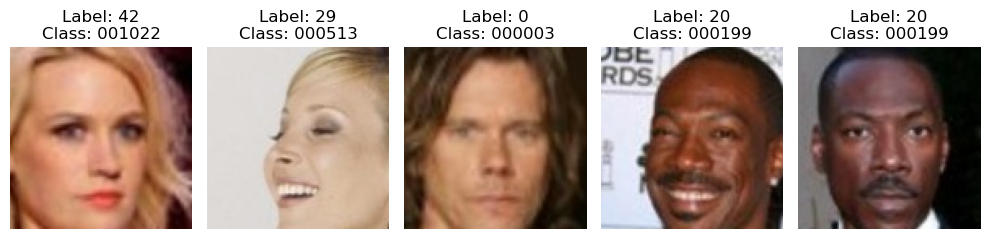

In [8]:
import random
import matplotlib.pyplot as plt

# Function to visualize random images with their labels
def visualize_random_samples(images, labels, label_map, num_samples=5):
    # Select random indices
    random_indices = random.sample(range(len(images)), num_samples)

    # Create a plot
    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(random_indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(cv2.cvtColor(images[idx].astype(np.uint8), cv2.COLOR_RGB2BGR))  # Convert BGR to RGB for proper display
        plt.title(f"Label: {labels[idx]}\nClass: {label_map[labels[idx]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Print the number of images and classes
print(f"Total Images: {images.shape[0]}")
print(f"Total Classes: {len(label_map)}")

# Visualize random samples
visualize_random_samples(images, labels, label_map)


## Flatten images for PCA

In [10]:
images_flattened = images.reshape(images.shape[0], -1)  # Flatten images

## Split data into training and testing sets

In [12]:
X_train, X_test, y_train, y_test = train_test_split(images_flattened, labels, test_size=0.2, random_state=42)

## Normalize the data using StandardScaler

In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Perform PCA 

In [16]:
n_components = 200  # Number of eigenfaces
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

## Function to plot the most significant eigenfaces


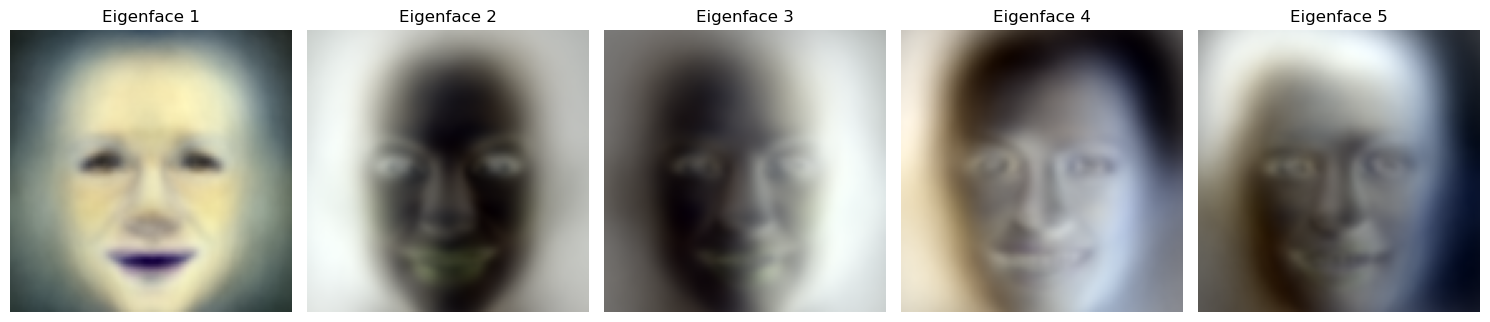

In [18]:
def plot_eigenfaces(pca, num_components=5):
    eigenfaces = pca.components_.reshape((n_components, 112, 112, 3))  # Reshape to 112x112x3

    # Plot the top num_components eigenfaces
    plt.figure(figsize=(15, 5))
    for i in range(num_components):
        plt.subplot(1, num_components, i + 1)
        # Normalize eigenface pixel values to [0, 1]
        eigenface = eigenfaces[i]
        eigenface = (eigenface - eigenface.min()) / (eigenface.max() - eigenface.min())
        plt.imshow(eigenface, cmap="gray")
        plt.title(f"Eigenface {i+1}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Plot the top 5 eigenfaces
plot_eigenfaces(pca, num_components=5)

## Train an SVM on PCA-transformed data

In [20]:
svc = SVC(kernel='rbf', C=78, gamma='scale', random_state=42)
svc.fit(X_train_pca, y_train)

SVC(C=78, random_state=42)

## Test the classifier

In [22]:
y_pred = svc.predict(X_test_pca)

## Evaluate the model's accuracy

In [24]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 70.19%


## Function to visualize random prediction results


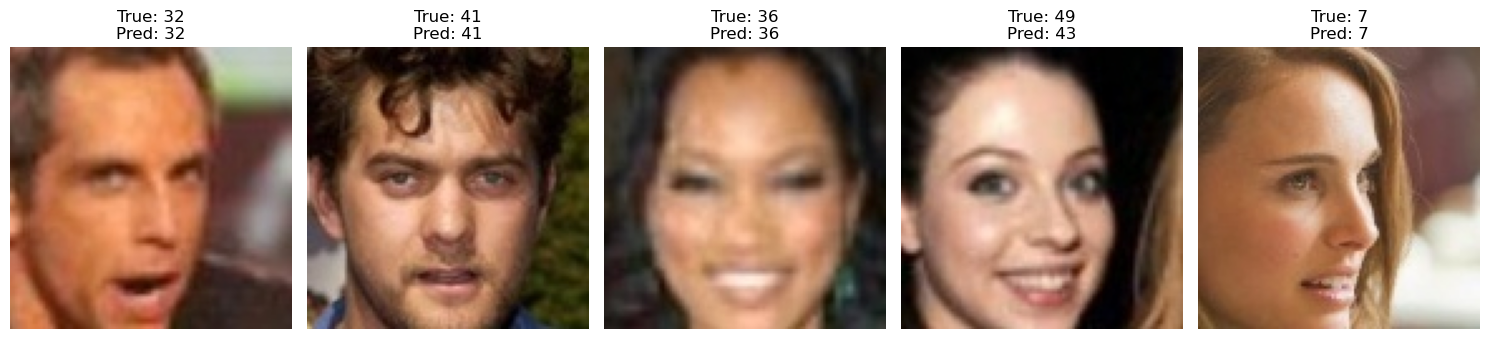

In [31]:
# Number of random samples to display
num_samples = 5

# Generate random indices for the samples
random_indices = np.random.randint(0, len(X_test), num_samples)

# Create a figure for displaying images
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

# Ensure axes is iterable even if there's only one axis
if num_samples == 1:
    axes = [axes]

for i, idx in enumerate(random_indices):
    # Get the test image and its true label
    test_image_flat = X_test[idx]  # Flattened image from X_test
    true_label = y_test[idx]
    
    # Rescale the image back to its original pixel values
    # Inverse transform using the scaler (reshaped to 2D for inverse transformation)
    test_image_rescaled = scaler.inverse_transform(test_image_flat.reshape(1, -1)).reshape(112, 112, 3)

    # Ensure the image values are in the valid range [0, 255] for display
    test_image_rescaled = np.clip(test_image_rescaled, 0, 255).astype(np.uint8)

    # Convert BGR to RGB if necessary (assuming images might be in BGR format)
    test_image_rescaled = cv2.cvtColor(test_image_rescaled, cv2.COLOR_BGR2RGB)  # Convert to RGB for proper visualization

    # Get the predicted label using the classifier
    predicted_label = svc.predict([X_test_pca[idx]])[0]
    
    # Display the image
    axes[i].imshow(test_image_rescaled)
    
    # Display the true and predicted labels as titles
    axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}")
    axes[i].axis('off')  # Hide axes for better visualization

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


## print the classification report

In [33]:
# Assuming y_test are the true labels and y_pred are the predicted labels
report = classification_report(
    y_test, 
    y_pred, 
    target_names=[label_map[i] for i in sorted(label_map.keys())], 
    zero_division=1  # Handling division by zero by setting precision to 1
)

print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      000003       0.56      0.61      0.59        75
      000014       0.63      0.72      0.67        72
      000018       0.72      0.63      0.67        73
      000021       0.82      0.76      0.79        71
      000023       0.51      0.79      0.62        75
      000025       0.69      0.61      0.65        74
      000034       0.54      0.56      0.55        71
      000037       0.52      0.72      0.60       115
      000039       0.93      0.69      0.79        80
      000041       0.68      0.72      0.70       123
      000046       0.76      0.50      0.60        64
      000047       0.83      0.77      0.80        82
      000069       0.77      0.69      0.72        86
      000085       0.78      0.75      0.76        63
      000086       0.88      0.77      0.82        60
      000088       0.80      0.70      0.74        73
      000136       0.67      0.54      0.60        52
    

## Plot the confusion matrix

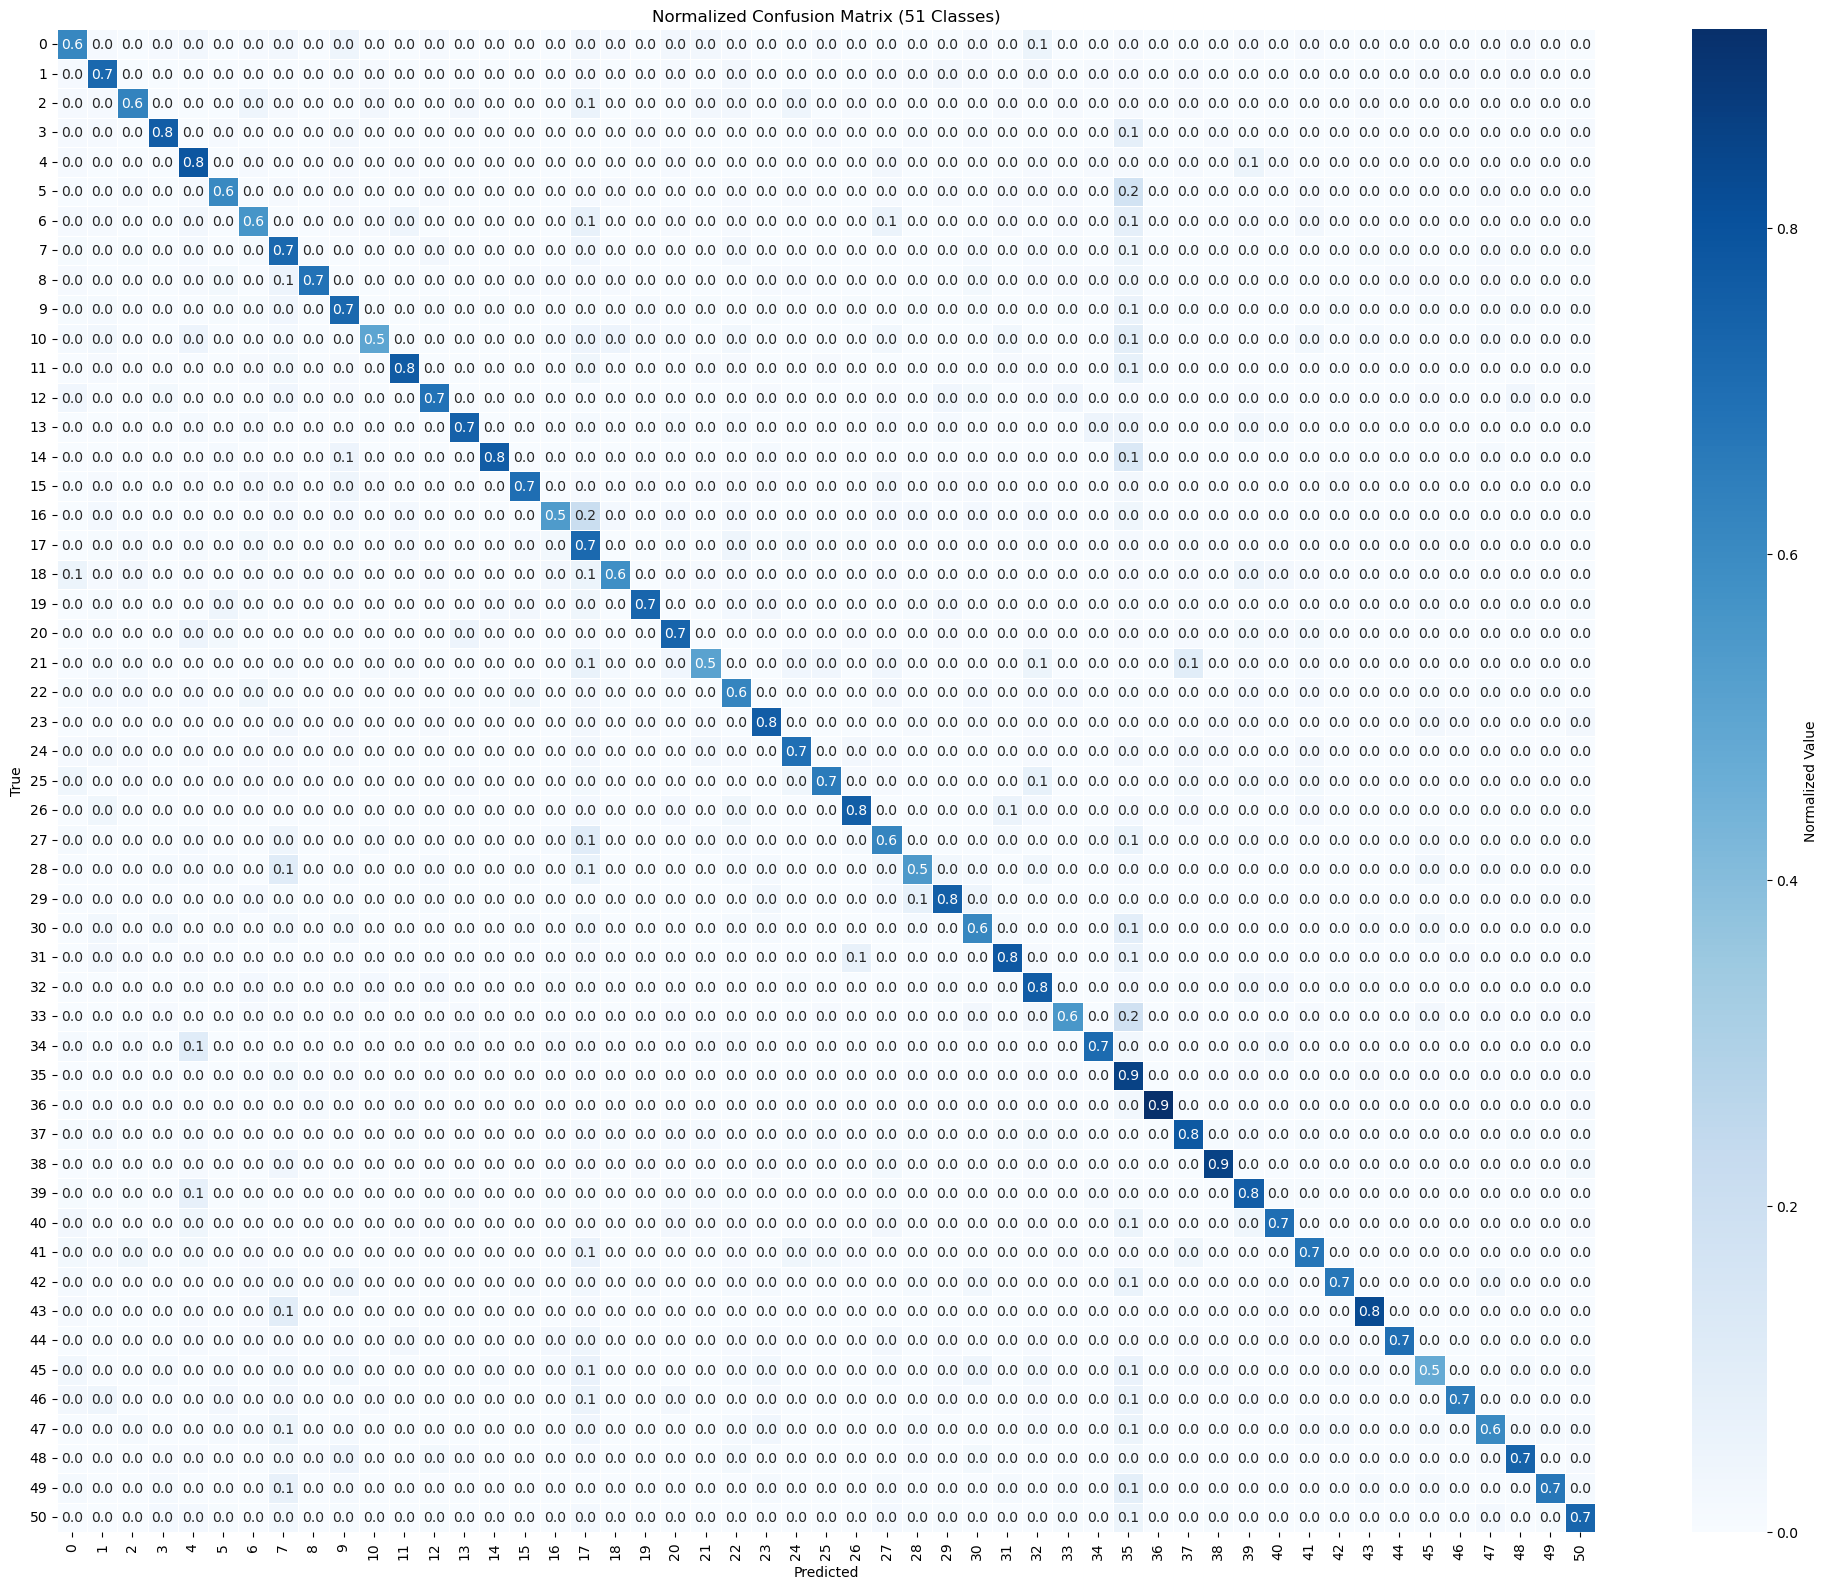

In [35]:
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix to show percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(20, 16))  # Increase figure size for better visibility
sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='Blues', 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), 
            cbar_kws={'label': 'Normalized Value'}, linewidths=0.5)

# Rotate the labels to prevent overlapping
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix (51 Classes)')

# Adjust layout for better readability
plt.tight_layout()
plt.show()
